In [1]:
import anndata
import numpy as np
import sys
import torch
sys.path.append('../../../../')
import velovae as vv

In [2]:
dataset = 'Braindev'
root = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')
adata.obs['clusters'] = adata.obs['Class'].to_numpy()

In [ ]:
#vv.preprocess(adata, n_gene=2000, min_shared_counts=20, compute_umap=True)

In [3]:
model_path_base = f'{root}/checkpoints/{dataset}_notime'
figure_path_base = f'{root}/figures/{dataset}_notime'
data_path = f'{root}/data/velovae/discrete/{dataset}_notime'
gene_plot = ['Mapt', 'Tmsb10', 'Fabp7', 'Npm1']

# Informative Time Prior

In [4]:
capture_time = adata.obs['Age'].to_numpy()
tprior = np.array([float(x[1:]) for x in capture_time])
adata.obs['tprior'] = tprior

## Discrete VAE

In [5]:
figure_path = f'{figure_path_base}/DVAE'
model_path = f'{model_path_base}/DVAE'


torch.manual_seed(2022)
np.random.seed(2022)

dvae = vv.model.VAE(adata, 
                    tmax=20, 
                    dim_z=5, 
                    device='cuda:0',
                    discrete=True,
                    init_method='tprior',
                    init_key='tprior',
                    tprior=None,
                    init_ton_zero=False)

dvae.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

dvae.save_model(model_path, 'encoder', 'decoder')
dvae.save_anndata(adata, 'dvae', data_path, f'{dataset}.h5ad')

Detecting zero scaling factors: 5, 0
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 1218 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using prior time.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

Initial induction: 1733, repression: 267/2000
Learning Rate based on Data Sparsity: 0.0009
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 164, test iteration: 326
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/29948 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.029
Average Set Size: 601
*********     Round 1: Early Stop Triggered at epoch 1187.    *********
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1339.    *********
Change in x0: 0.2237
*********             Velocity Refinement Round 3             *********
Change in x0: 0.1248
*********             Velocity Refinement Round 4             *********
Change in x0: 0.1274
*********             Velocity Refinement Round 5             *********
Stage 2: Early Stop Triggered at round 4.
*********              Finished. Total Time =   1 h : 38 m :  7 s             *********
Final: Train ELBO = -1259.580,	Test ELBO = -1271.809


# Discrete FullVB

In [7]:
figure_path = f'{figure_path_base}/DFullVB'
model_path = f'{model_path_base}/DFullVB'

torch.manual_seed(2022)
np.random.seed(2022)
dfullvb = vv.model.VAE(adata, 
                       tmax=20, 
                       dim_z=5, 
                       device='cuda:0',
                       discrete=True,
                       full_vb=True,
                       init_method='tprior',
                       init_key='tprior',
                       tprior=None,
                       init_ton_zero=False)

dfullvb.train(adata, plot=False, gene_plot=gene_plot, figure_path=figure_path)

dfullvb.save_model(model_path, 'encoder', 'decoder')
dfullvb.save_anndata(adata, 'dfullvb', data_path, f'{dataset}.h5ad')

Detecting zero scaling factors: 5, 0
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 1218 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using prior time.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

Initial induction: 1733, repression: 267/2000
Learning Rate based on Data Sparsity: 0.0009
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 164, test iteration: 326
*********       Stage 1: Early Stop Triggered at epoch 935.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/29948 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 601
*********     Round 1: Early Stop Triggered at epoch 1005.    *********
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1143.    *********
Change in x0: 0.1867
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1205.    *********
Change in x0: 0.1301
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1561.    *********
Change in x0: 0.1114
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1591.    *********
Change in x0: 0.0986
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at epoch 1639.    *********
Change in x0: 0.0909
*********             Velocity Refinement Round

# Evaluation

In [6]:
dataset = 'Braindev'
root = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(f'{root}/data/velovae/discrete/{dataset}_notime/{dataset}.h5ad')

computing velocity graph (using 1/36 cores)


  0%|          | 0/29948 [00:00<?, ?cells/s]

    finished (0:00:40) --> added 
    'dfullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'dfullvb_velocity_umap', embedded velocity vectors (adata.obsm)


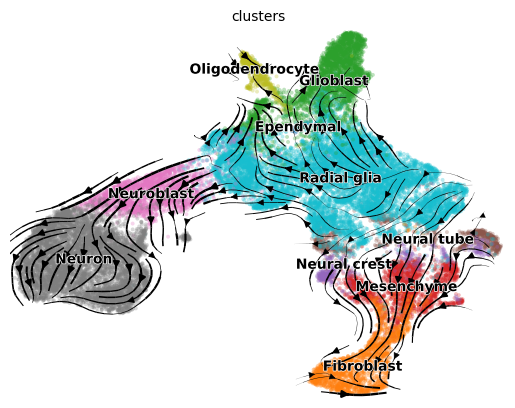

In [7]:
import scvelo as scv
vel_genes = np.load('/scratch/blaauw_root/blaauw1/gyichen/perf/Braindev_scv_vel_genes.npy')
scv.tl.velocity_graph(adata, vkey='dfullvb_velocity', gene_subset=adata.var_names[vel_genes])
scv.pl.velocity_embedding_stream(adata, vkey='dfullvb_velocity')

['Rsrc1']
---   Plotting  Results   ---


(None, None)

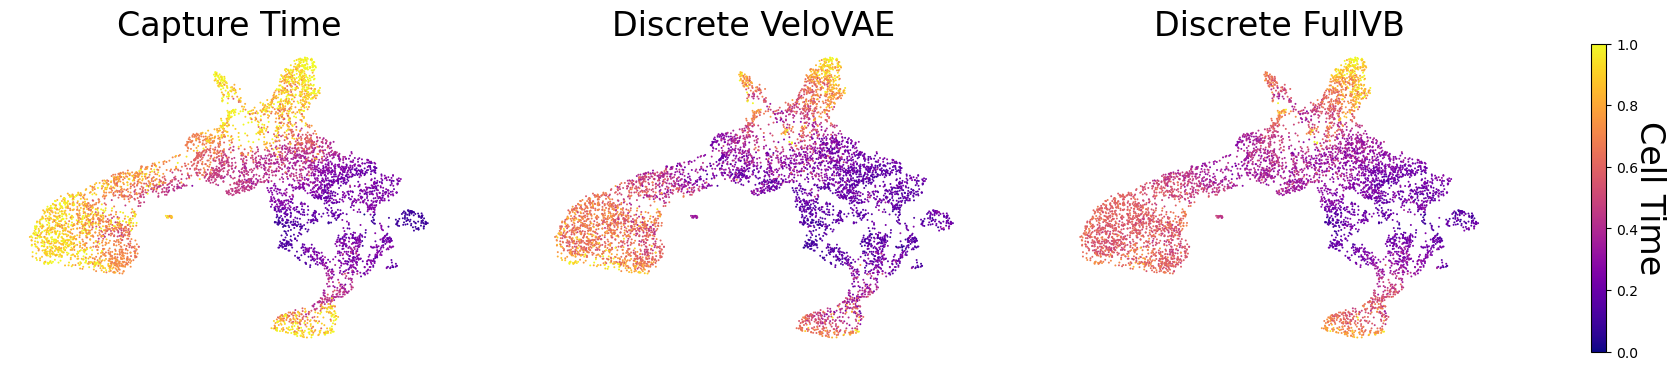

In [8]:
vv.post_analysis(adata,
                 'eval',
                 ['Discrete VeloVAE','Discrete FullVB'],
                 ['dvae','dfullvb'],
                 compute_metrics=False,
                 plot_type=['time'],
                 figure_path=None)